In [1]:
import skimage
import os
from skimage import io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.color import rgb2hsv
import re
import numpy as np
import seaborn as sns
## for the stats class
import scipy.signal as sg
from skimage.transform import rescale, resize, downscale_local_mean

import pywt
from scipy import stats
import timeit

# import scipy.io as sio
import h5py
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns
import pandas as pd
from datetime import datetime
import pytz
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from skimage import io
from patchify import patchify, unpatchify
%matplotlib inline

import collections
# from itertools import chain
# import urllib.request as request
# import pickle

import numpy as np

import scipy.signal as signal
import scipy.special as special
import scipy.optimize as optimize

import matplotlib.pyplot as plt

import skimage.io
import skimage.transform

# import cv2
from sklearn import preprocessing

# from libsvm import svmutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

In [2]:
def plot_confusion_matrix(y_test, y_test_pred, model_name):
    test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
    group_names = ['True Negative (TN)', 'False Positive (FP)',
                'False Negative (FN)', 'True Positive (TP)']
    group_counts = ["{0:0.0f}".format(value) for value in test_confusion_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in test_confusion_matrix.flatten()/np.sum(test_confusion_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    # Creating the heatmap
    plt.figure(figsize=(8,5))
    sns.heatmap(test_confusion_matrix, annot=labels, fmt='', cmap='Blues', vmin = 0)
    # plt.title("Confusion Matrix for "+ model_name+ " (using Test Set)")
    plt.ylabel('True label', fontsize = 16)
    plt.xlabel('Predicted label', fontsize = 16)

    plt.show()

In [3]:
def balance_dataset(X, y):
    # Separate the data into classes
    class_0_indices = np.where(y == 0)[0]
    class_1_indices = np.where(y == 1)[0]

    # Sample an equal number of samples from each class
    num_samples_per_class = min(len(class_0_indices), len(class_1_indices))

    # Randomly sample indices for each class
    sampled_indices_class_0 = np.random.choice(class_0_indices, num_samples_per_class, replace=False)
    sampled_indices_class_1 = np.random.choice(class_1_indices, num_samples_per_class, replace=False)

    # Combine the sampled indices
    sampled_indices = np.concatenate([sampled_indices_class_0, sampled_indices_class_1])

    # Use the sampled indices to create the balanced training set
    X_balanced = X[sampled_indices]
    y_balanced = y[sampled_indices]
    
    # Check the balance in y_train_balanced
    print(np.bincount(y_balanced))

    return(X_balanced, y_balanced)

In [4]:
def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], angle=180 + angle, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")


In [6]:
# fog_aware_pivot = pd.read_csv('fog_aware_stats_4_equal_patches_pivot.csv')
# fog_aware_pivot = pd.read_csv('fog_aware_stats_no_patches_pivot.csv')
# fog_aware_pivot = pd.read_csv('fog_aware_stats_4_equal_patches_pivot.csv')
fog_aware_pivot = pd.read_csv('/home/smmrrr/Fog_Imaging_Project/STA_221_project_code/analyses_files/fog_aware_stats_horizontal_3_patches_pivot.csv')
fog_aware_pivot['Label_train'] = 1*(fog_aware_pivot['Label']=='foggy')
fog_aware_pivot

,photo,Label,site,hour,mscn_var_0,mscn_var_1,mscn_var_2,vertical_var_0,vertical_var_1,vertical_var_2,...,dark_channel_prior_0,dark_channel_prior_1,dark_channel_prior_2,color_sat_0,color_sat_1,color_sat_2,CF_0,CF_1,CF_2,Label_train
0,2022_07-04.0000_agatebeachor.jpg,not_foggy,agatebeachor,0,0.220805,0.285012,0.099900,0.065638,0.106588,0.034401,...,28.0,6.0,14.0,0.000000,0.000000,0.000000,85.593872,51.769043,10.103722,0
1,2022_07-04.0000_otterrockor.jpg,not_foggy,otterrockor,0,0.725298,0.720047,0.691137,0.493167,0.477681,0.461369,...,2.0,4.0,0.0,0.244513,0.152914,0.160079,90.752732,158.670973,166.963307,0
2,2022_07-04.0700_agatebeachor.jpg,not_foggy,agatebeachor,7,0.096299,0.131353,0.173731,0.015461,0.041110,0.050096,...,64.0,24.0,37.0,0.000000,0.000000,0.000000,35.000917,18.467704,9.174465,0
3,2022_07-04.0730_agatebeachor.jpg,not_foggy,agatebeachor,7,0.101561,0.205493,0.325304,0.016175,0.091502,0.142794,...,95.0,13.0,20.0,0.063917,0.072188,0.164992,105.608782,106.996344,147.341268,0
4,2022_07-04.0730_otterrockor.jpg,not_foggy,otterrockor,7,0.251876,0.576411,0.588961,0.082378,0.292454,0.396829,...,7.0,0.0,0.0,0.099916,0.042100,0.124894,110.066753,189.517876,183.865692,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7991,2023_09-30.1900_agatebeachor.jpg,not_foggy,agatebeachor,19,0.176457,0.743293,0.523022,0.083535,0.457137,0.265502,...,70.0,0.0,0.0,0.041942,0.085205,0.077075,182.964334,69.402653,135.332656,0
7992,2023_09-30.1930_cannonbeach.jpg,not_foggy,cannonbeach,19,0.164592,0.585149,0.640644,0.042335,0.314184,0.390172,...,0.0,0.0,0.0,0.039959,0.058892,0.092489,137.364165,106.650678,174.568957,0
7993,2023_09-30.2000_otterrockor.jpg,not_foggy,otterrockor,20,0.282921,0.442290,0.345411,0.136875,0.235093,0.183542,...,22.0,3.0,0.0,0.125098,0.145597,0.143351,176.593142,127.302494,142.248589,0
7994,2023_09-30.2030_otterrockor.jpg,not_foggy,otterrockor,20,0.193967,0.582705,0.378667,0.059283,0.307785,0.207709,...,26.0,0.0,0.0,0.137039,0.243238,0.247271,175.215470,145.617058,152.212567,0


In [7]:
fog_aware_pivot.loc[fog_aware_pivot['photo']=='2022_07-05.1100_beverlyor.jpg']

,photo,Label,site,hour,mscn_var_0,mscn_var_1,mscn_var_2,vertical_var_0,vertical_var_1,vertical_var_2,...,dark_channel_prior_0,dark_channel_prior_1,dark_channel_prior_2,color_sat_0,color_sat_1,color_sat_2,CF_0,CF_1,CF_2,Label_train
116,2022_07-05.1100_beverlyor.jpg,foggy,beverlyor,11,0.10654,0.273032,0.61789,0.023069,0.091905,0.388489,...,139.0,66.0,0.0,0.017764,0.016792,0.116925,40.404816,84.938373,157.623462,1


In [8]:
fog_aware_pivot[['Label_train', 'Label']].value_counts()

Label_train  Label    
0            not_foggy    6374
1            foggy        1622
dtype: int64

In [10]:
fog_aware_pivot
np.array(fog_aware_pivot.columns[fog_aware_pivot.columns.str.contains(r'_1|Label$')])

array(['Label', 'mscn_var_1', 'vertical_var_1', 'sharpness_1',
       'coef_or_var_sharpness_1', 'rms_contrast_1', 'entropy_1',
       'dark_channel_prior_1', 'color_sat_1', 'CF_1'], dtype=object)

In [110]:

fog_aware_pivot.loc[fog_aware_pivot['site'] == 'agatebeachor','site'] = 'Agate Beach'
fog_aware_pivot.loc[fog_aware_pivot['site'] == 'lincolncityor','site'] = 'Lincoln City'
fog_aware_pivot.loc[fog_aware_pivot['site'] == 'pacificcityor','site'] = 'Pacific City'
fog_aware_pivot.loc[fog_aware_pivot['site'] == 'beverlyor','site'] = 'Beverly'
fog_aware_pivot.loc[fog_aware_pivot['site'] == 'otterrockor','site'] = 'Otter Rock'
fog_aware_pivot.loc[fog_aware_pivot['site'] == 'cannonbeach','site'] = 'Cannon Beach'


In [158]:
# g = sns.pairplot(fog_aware_pivot.drop(['photo', 'site', 'hour', 'Label_train'], axis = 1)
#                  , hue = 'Label', palette={'foggy': 'blue', 'not_foggy': 'green'}, markers=["o", "D"]
#                  , corner=True)

# g = sns.pairplot(fog_aware_pivot[fog_aware_pivot.columns[fog_aware_pivot.columns.str.contains(r'_1|Label$')]]
#                  , hue = 'Label', palette={'foggy': 'blue', 'not_foggy': 'green'}, markers=["o", "D"]
#                  , corner=True)


In [17]:

####create summary stat datasets
gmm_summary_stats = pd.DataFrame(columns = ['site',
"Accuracy",
"Precision",
"Recall",
"F1 Score",
"AUC"
])

precision_recall = pd.DataFrame(columns = ['site','precision_array', 'recall_array' ])
roc = pd.DataFrame(columns = ['site','fpr', 'tpr'])
y_info = pd.DataFrame(columns = ['site','y_test','y_test_pred', 'y_scores'])

##define columns to keep in analysis
to_keep_3_patches = ['mscn_var_1',
'vertical_var_1',
'sharpness_1',
'coef_or_var_sharpness_1',
'rms_contrast_1']

# to_keep_3_patches = ['dark_channel_prior_1',
# 'color_sat_1',
# 'sharpness_1',
# 'coef_or_var_sharpness_1',
# 'rms_contrast_1']

site = 'Best Set'
X = np.array(fog_aware_pivot[to_keep_3_patches]
            )
# X = np.array(fog_aware_site.drop(['photo', 'Label', 'site', 'hour', 'Label_train'], axis = 1)
#             )

y = fog_aware_pivot['Label_train']

####create a 50/50 dataset of foggy not foggy
X_balanced, y_balanced = balance_dataset(X, y)


###scale the data to 0, 1
scaler = preprocessing.StandardScaler().fit(X_balanced)
X_scaled = scaler.transform(X_balanced)

####train test split
X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_balanced, test_size=0.25
    # , random_state=42
    , stratify = y_balanced)

n_classes = len(np.unique(y_train))

gmm = GaussianMixture(n_components=n_classes
                    # ,covariance_type='full' ##this covariance type works best
                      # , max_iter=20, random_state=0
                     )
gmm.fit(X_train)
y_train_pred = gmm.predict(X_train)
y_test_pred = gmm.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
# print("AUC-ROC Score:", roc_auc)
print(confusion_matrix(y_test, y_test_pred))
tt = confusion_matrix(y_test, y_test_pred)

y_scores = gmm.predict_proba(X_test)[:, 1]
# y_scores = gmm.predict(X_test)

# Calculate precision and recall for various thresholds
precision_array, recall_array, thresholds = precision_recall_curve(y_test, y_scores)

fpr, tpr, thresholds = roc_curve(y_test, gmm.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)



####gmm summary stats
gmm_summary_stats = pd.concat([gmm_summary_stats,
                               pd.DataFrame({'site':[site],
                "Accuracy":[accuracy],
                "Precision":[precision],
                "Recall":[recall],
                "F1 Score":[f1],
                "AUC":[roc_auc]
                                            })
            ], axis = 0)

#### precision recall 
precision_recall = pd.concat([precision_recall
,pd.DataFrame({'site':site,'precision_array':precision_array, 'recall_array':recall_array })
],axis=0)
###roc chart
roc = pd.concat([roc
,pd.DataFrame({'site':site,'fpr':fpr, 'tpr':tpr})
],axis=0)
##prediction info
y_info = pd.concat([y_info
,pd.DataFrame({'site':site,'y_test':y_test,'y_test_pred':y_test_pred, 'y_scores':y_scores})
],axis=0)




[1622 1622]
Accuracy: 0.8113440197287299
Precision: 0.9012738853503185
Recall: 0.6987654320987654
F1 Score: 0.7872044506258693
[[375  31]
 [122 283]]


In [126]:
# ##define columns to keep in analysis
# to_keep_3_patches = ['mscn_var_1',
# 'vertical_var_1',
# 'dark_channel_prior_1',
# 'coef_or_var_sharpness_1',
# 'rms_contrast_1']

to_keep_3_patches = ['dark_channel_prior_1',
'color_sat_1',
'rms_contrast_0',
'coef_or_var_sharpness_1',
'rms_contrast_1']

site = 'Top 5 SHAP'
X = np.array(fog_aware_pivot[to_keep_3_patches]
            )
# X = np.array(fog_aware_site.drop(['photo', 'Label', 'site', 'hour', 'Label_train'], axis = 1)
#             )

y = fog_aware_pivot['Label_train']

####create a 50/50 dataset of foggy not foggy
X_balanced, y_balanced = balance_dataset(X, y)


###scale the data to 0, 1
scaler = preprocessing.StandardScaler().fit(X_balanced)
X_scaled = scaler.transform(X_balanced)

####train test split
X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_balanced, test_size=0.25, random_state=42, stratify = y_balanced)

n_classes = len(np.unique(y_train))

gmm = GaussianMixture(n_components=n_classes
                    # ,covariance_type='full' ##this covariance type works best
                      # , max_iter=20, random_state=0
                     )
gmm.fit(X_train)
y_train_pred = gmm.predict(X_train)
y_test_pred = gmm.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)

while accuracy < 0.45:  ###in case the model gets the 1s and 0s mixed up
    gmm = GaussianMixture(n_components=n_classes
                        # ,covariance_type='diag' ##this covariance type works best
                         )
    gmm.fit(X_train)
    y_train_pred = gmm.predict(X_train)
    y_test_pred = gmm.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    print(accuracy)

# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
# print("AUC-ROC Score:", roc_auc)
print(confusion_matrix(y_test, y_test_pred))
tt = confusion_matrix(y_test, y_test_pred)

y_scores = gmm.predict_proba(X_test)[:, 1]
# y_scores = gmm.predict(X_test)

# Calculate precision and recall for various thresholds
precision_array, recall_array, thresholds = precision_recall_curve(y_test, y_scores)

fpr, tpr, thresholds = roc_curve(y_test, gmm.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)



####gmm summary stats
gmm_summary_stats = pd.concat([gmm_summary_stats,
                               pd.DataFrame({'site':[site],
                "Accuracy":[accuracy],
                "Precision":[precision],
                "Recall":[recall],
                "F1 Score":[f1],
                "AUC":[roc_auc]
                                            })
            ], axis = 0)

#### precision recall 
precision_recall = pd.concat([precision_recall
,pd.DataFrame({'site':site,'precision_array':precision_array, 'recall_array':recall_array })
],axis=0)
###roc chart
roc = pd.concat([roc
,pd.DataFrame({'site':site,'fpr':fpr, 'tpr':tpr})
],axis=0)
##prediction info
y_info = pd.concat([y_info
,pd.DataFrame({'site':site,'y_test':y_test,'y_test_pred':y_test_pred, 'y_scores':y_scores})
],axis=0)


[1622 1622]
Accuracy: 0.8002466091245376
Precision: 0.7332053742802304
Recall: 0.9432098765432099
F1 Score: 0.8250539956803455
[[267 139]
 [ 23 382]]


In [127]:
# ##define columns to keep in analysis
# to_keep_3_patches = ['mscn_var_1',
# 'vertical_var_1',
# 'dark_channel_prior_1',
# 'coef_or_var_sharpness_1',
# 'rms_contrast_1']

to_keep_3_patches = ['dark_channel_prior_1',
'coef_or_var_sharpness_1',
'rms_contrast_1']

site = 'Top 3 SHAP'
X = np.array(fog_aware_pivot[to_keep_3_patches]
            )
# X = np.array(fog_aware_site.drop(['photo', 'Label', 'site', 'hour', 'Label_train'], axis = 1)
#             )

y = fog_aware_pivot['Label_train']

####create a 50/50 dataset of foggy not foggy
X_balanced, y_balanced = balance_dataset(X, y)


###scale the data to 0, 1
scaler = preprocessing.StandardScaler().fit(X_balanced)
X_scaled = scaler.transform(X_balanced)

####train test split
X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_balanced, test_size=0.25, random_state=42, stratify = y_balanced)

n_classes = len(np.unique(y_train))

gmm = GaussianMixture(n_components=n_classes
                    # ,covariance_type='full' ##this covariance type works best
                      # , max_iter=20, random_state=0
                     )
gmm.fit(X_train)
y_train_pred = gmm.predict(X_train)
y_test_pred = gmm.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)

while accuracy < 0.45:  ###in case the model gets the 1s and 0s mixed up
    gmm = GaussianMixture(n_components=n_classes
                        # ,covariance_type='diag' ##this covariance type works best
                         )
    gmm.fit(X_train)
    y_train_pred = gmm.predict(X_train)
    y_test_pred = gmm.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    print(accuracy)

# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
# print("AUC-ROC Score:", roc_auc)
print(confusion_matrix(y_test, y_test_pred))
tt = confusion_matrix(y_test, y_test_pred)

y_scores = gmm.predict_proba(X_test)[:, 1]
# y_scores = gmm.predict(X_test)

# Calculate precision and recall for various thresholds
precision_array, recall_array, thresholds = precision_recall_curve(y_test, y_scores)

fpr, tpr, thresholds = roc_curve(y_test, gmm.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)



####gmm summary stats
gmm_summary_stats = pd.concat([gmm_summary_stats,
                               pd.DataFrame({'site':[site],
                "Accuracy":[accuracy],
                "Precision":[precision],
                "Recall":[recall],
                "F1 Score":[f1],
                "AUC":[roc_auc]
                                            })
            ], axis = 0)

#### precision recall 
precision_recall = pd.concat([precision_recall
,pd.DataFrame({'site':site,'precision_array':precision_array, 'recall_array':recall_array })
],axis=0)
###roc chart
roc = pd.concat([roc
,pd.DataFrame({'site':site,'fpr':fpr, 'tpr':tpr})
],axis=0)
##prediction info
y_info = pd.concat([y_info
,pd.DataFrame({'site':site,'y_test':y_test,'y_test_pred':y_test_pred, 'y_scores':y_scores})
],axis=0)


[1622 1622]
0.22564734895191121
0.22564734895191121
0.7743526510480888
Accuracy: 0.7743526510480888
Precision: 0.707089552238806
Recall: 0.9358024691358025
F1 Score: 0.8055260361317746
[[249 157]
 [ 26 379]]


In [130]:

site = 'All Variables'
X = np.array(fog_aware_pivot.drop(['photo', 'Label', 'site', 'hour', 'Label_train'], axis = 1)
            )

y = fog_aware_pivot['Label_train']

####create a 50/50 dataset of foggy not foggy
X_balanced, y_balanced = balance_dataset(X, y)


###scale the data to 0, 1
scaler = preprocessing.StandardScaler().fit(X_balanced)
X_scaled = scaler.transform(X_balanced)

####train test split
X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_balanced, test_size=0.25, random_state=42, stratify = y_balanced)

n_classes = len(np.unique(y_train))

gmm = GaussianMixture(n_components=n_classes
                    # ,covariance_type='full' ##this covariance type works best
                      # , max_iter=20, random_state=0
                     )
gmm.fit(X_train)
y_train_pred = gmm.predict(X_train)
y_test_pred = gmm.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)

while accuracy < 0.45:  ###in case the model gets the 1s and 0s mixed up
    gmm = GaussianMixture(n_components=n_classes
                        # ,covariance_type='diag' ##this covariance type works best
                         )
    gmm.fit(X_train)
    y_train_pred = gmm.predict(X_train)
    y_test_pred = gmm.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    print(accuracy)

# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
# print("AUC-ROC Score:", roc_auc)
print(confusion_matrix(y_test, y_test_pred))
tt = confusion_matrix(y_test, y_test_pred)

y_scores = gmm.predict_proba(X_test)[:, 1]
# y_scores = gmm.predict(X_test)

# Calculate precision and recall for various thresholds
precision_array, recall_array, thresholds = precision_recall_curve(y_test, y_scores)

fpr, tpr, thresholds = roc_curve(y_test, gmm.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)



####gmm summary stats
gmm_summary_stats = pd.concat([gmm_summary_stats,
                               pd.DataFrame({'site':[site],
                "Accuracy":[accuracy],
                "Precision":[precision],
                "Recall":[recall],
                "F1 Score":[f1],
                "AUC":[roc_auc]
                                            })
            ], axis = 0)

#### precision recall 
precision_recall = pd.concat([precision_recall
,pd.DataFrame({'site':site,'precision_array':precision_array, 'recall_array':recall_array })
],axis=0)
###roc chart
roc = pd.concat([roc
,pd.DataFrame({'site':site,'fpr':fpr, 'tpr':tpr})
],axis=0)
##prediction info
y_info = pd.concat([y_info
,pd.DataFrame({'site':site,'y_test':y_test,'y_test_pred':y_test_pred, 'y_scores':y_scores})
],axis=0)


[1622 1622]
0.1442663378545006
0.8557336621454994
Accuracy: 0.8557336621454994
Precision: 0.8956043956043956
Recall: 0.8049382716049382
F1 Score: 0.847854356306892
[[368  38]
 [ 79 326]]


In [131]:
gmm_summary_stats

,site,Accuracy,Precision,Recall,F1 Score,AUC
0,Best Set,0.836005,0.927673,0.728395,0.816044,0.930937
0,Top 5 SHAP,0.800247,0.733205,0.943210,0.825054,0.809895
0,Top 3 SHAP,0.774353,0.707090,0.935802,0.805526,0.785632
0,All Variables,0.855734,0.895604,0.804938,0.847854,0.924713


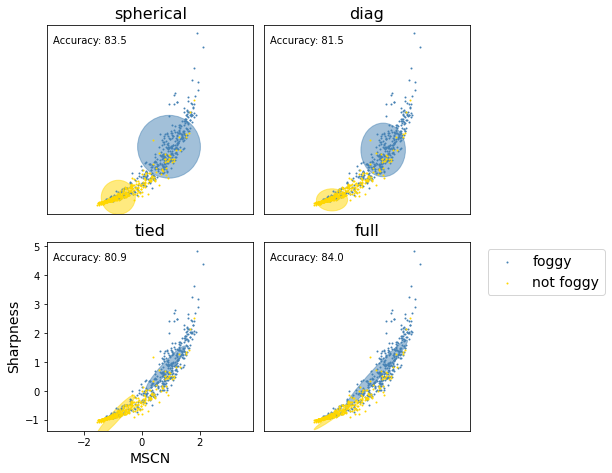

In [27]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

colors = ["steelblue", "gold"]
names = ["foggy", "not foggy"]

# Try GMMs using different types of covariances.
estimators = {
    cov_type: GaussianMixture(
        n_components=n_classes, covariance_type=cov_type#, max_iter=20, random_state=0
    )
    for cov_type in ["spherical", "diag", "tied", "full"]
}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(
    bottom=0.01, top=0.95, hspace=0.15, wspace=0.05, left=0.01, right=0.99
)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array(
        [X_train[y_train == i].mean(axis=0) for i in range(n_classes)]
    )

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    # for n, color in enumerate(colors):
    #     data = X[y == n]
    #     plt.scatter(
    #         data[:, 0], data[:, 2], s=0.8, color=color, label=names[n]
    #     )
    # # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 2], s=1, label=names[n]
                    # , marker="x"
                    , color=color)

    # y_train_pred = estimator.predict(X_train)
    # # train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    # train_accuracy = accuracy_score(y_train, y_train_pred)*100
    # plt.text(0.3, 0.1, "Foggy train accuracy: %.1f" % train_accuracy, transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    # test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    test_accuracy = accuracy_score(y_test, y_test_pred)*100
    plt.text(0.03, 0.90, "Accuracy: %.1f" % test_accuracy, transform=h.transAxes)

    # plt.xlim(0.6, .7)

    if index == 2:
        plt.xlabel('MSCN', fontsize = 14)
        plt.ylabel('Sharpness', fontsize = 14)
    else:
        plt.xticks(())
        plt.yticks(())
    plt.title(name, fontsize = 16)
    # plt.ylim(y_min, y_max)
# plt.xlim(0, .5)

lgnd = plt.legend(
    # title='Custom Label', 
                  bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 14 
                                                                   })
# plt.legend(scatterpoints=1, loc="center right", prop=dict(size=12))


plt.show()


In [135]:
X_train[0,:]

array([-0.17553127,  1.00600977,  1.6394665 , -0.35503086,  1.05643003,
        2.16879692, -0.3988287 ,  1.30845694,  1.71671896, -0.46615138,
        1.79240924,  1.85301351, -0.59016906,  1.59106093,  0.26195585,
       -0.16006624,  0.95194915,  0.0351066 , -0.50753444, -0.87238098,
       -0.62273139,  3.98801205,  4.23395364,  2.44894878,  0.06988858,
       -0.19235719, -0.24418741])

In [68]:


####loop through sites
for site in fog_aware_pivot.site.unique():
    
    print(site)    
    fog_aware_site = fog_aware_pivot.loc[fog_aware_pivot['site'] == site].reset_index()

    X = np.array(fog_aware_site[to_keep_3_patches]
                )
    # X = np.array(fog_aware_site.drop(['photo', 'Label', 'site', 'hour', 'Label_train'], axis = 1)
    #             )

    y = fog_aware_site['Label_train']

    ####create a 50/50 dataset of foggy not foggy
    X_balanced, y_balanced = balance_dataset(X, y)


    ###scale the data to 0, 1
    scaler = preprocessing.StandardScaler().fit(X_balanced)
    X_scaled = scaler.transform(X_balanced)

    ####train test split
    X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y_balanced, test_size=0.25, random_state=42, stratify = y_balanced)

    n_classes = len(np.unique(y_train))

    gmm = GaussianMixture(n_components=n_classes
                        # ,covariance_type='full' ##this covariance type works best
                         )
    gmm.fit(X_train)
    y_train_pred = gmm.predict(X_train)
    y_test_pred = gmm.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_test_pred)

    while accuracy < 0.45:  ###in case the model gets the 1s and 0s mixed up
        gmm = GaussianMixture(n_components=n_classes
                            # ,covariance_type='diag' ##this covariance type works best
                             )
        gmm.fit(X_train)
        y_train_pred = gmm.predict(X_train)
        y_test_pred = gmm.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_test_pred)
        print(accuracy)

#         if accuracy < 0.4: ###in case the model gets the 1s and 0s mixed up AGAIN
#             gmm = GaussianMixture(n_components=n_classes
#                                 ,covariance_type='diag' ##this covariance type works best
#                                  )
#             gmm.fit(X_train)
#             y_train_pred = gmm.predict(X_train)
#             y_test_pred = gmm.predict(X_test)

#             # Calculate metrics
#             accuracy = accuracy_score(y_test, y_test_pred)

#             if accuracy < 0.4: ###in case the model gets the 1s and 0s mixed up AGAIN
#                 gmm = GaussianMixture(n_components=n_classes
#                                     ,covariance_type='diag' ##this covariance type works best
#                                      )
#                 gmm.fit(X_train)
#                 y_train_pred = gmm.predict(X_train)
#                 y_test_pred = gmm.predict(X_test)

#                 # Calculate metrics
#                 accuracy = accuracy_score(y_test, y_test_pred)

    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    # Print the metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    # print("AUC-ROC Score:", roc_auc)
    print(confusion_matrix(y_test, y_test_pred))
    tt = confusion_matrix(y_test, y_test_pred)

    y_scores = gmm.predict_proba(X_test)[:, 1]
    # y_scores = gmm.predict(X_test)

    # Calculate precision and recall for various thresholds
    precision_array, recall_array, thresholds = precision_recall_curve(y_test, y_scores)

    fpr, tpr, thresholds = roc_curve(y_test, gmm.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)



    ####gmm summary stats
    gmm_summary_stats = pd.concat([gmm_summary_stats,
                                   pd.DataFrame({'site':[site],
                    "Accuracy":[accuracy],
                    "Precision":[precision],
                    "Recall":[recall],
                    "F1 Score":[f1],
                    "AUC":[roc_auc]
                                                })
                ], axis = 0)

    #### precision recall 
    precision_recall = pd.concat([precision_recall
    ,pd.DataFrame({'site':site,'precision_array':precision_array, 'recall_array':recall_array })
    ],axis=0)
    ###roc chart
    roc = pd.concat([roc
    ,pd.DataFrame({'site':site,'fpr':fpr, 'tpr':tpr})
    ],axis=0)
    ##prediction info
    y_info = pd.concat([y_info
    ,pd.DataFrame({'site':site,'y_test':y_test,'y_test_pred':y_test_pred, 'y_scores':y_scores})
    ],axis=0)




Agate Beach
[335 335]
0.13690476190476192
0.13690476190476192
0.8630952380952381
Accuracy: 0.8630952380952381
Precision: 0.8860759493670886
Recall: 0.8333333333333334
F1 Score: 0.8588957055214723
[[75  9]
 [14 70]]
Otter Rock
[217 217]
0.8440366972477065
Accuracy: 0.8440366972477065
Precision: 0.8775510204081632
Recall: 0.7962962962962963
F1 Score: 0.8349514563106796
[[49  6]
 [11 43]]
Beverly
[137 137]
Accuracy: 0.8840579710144928
Precision: 0.90625
Recall: 0.8529411764705882
F1 Score: 0.8787878787878787
[[32  3]
 [ 5 29]]
Pacific City
[209 209]
Accuracy: 0.9238095238095239
Precision: 0.9782608695652174
Recall: 0.8653846153846154
F1 Score: 0.9183673469387755
[[52  1]
 [ 7 45]]
Lincoln City
[494 494]
Accuracy: 0.8259109311740891
Precision: 0.8389830508474576
Recall: 0.8048780487804879
F1 Score: 0.8215767634854773
[[105  19]
 [ 24  99]]
Cannon Beach
[230 230]
0.6434782608695652
Accuracy: 0.6434782608695652
Precision: 0.6290322580645161
Recall: 0.6842105263157895
F1 Score: 0.655462184873

In [34]:
gmm_summary_stats

,site,Accuracy,Precision,Recall,F1 Score,AUC
0,all_sites,0.840937,0.939490,0.728395,0.820584,0.929326
0,Agate Beach,0.821429,0.813953,0.833333,0.823529,0.914399
0,Otter Rock,0.816514,0.826923,0.796296,0.811321,0.893603
0,Beverly,0.695652,1.000000,0.382353,0.553191,0.926050
0,Pacific City,0.885714,0.934783,0.826923,0.877551,0.945392
0,Lincoln City,0.785425,0.801724,0.756098,0.778243,0.878836
0,Cannon Beach,0.730435,0.691176,0.824561,0.752000,0.862371


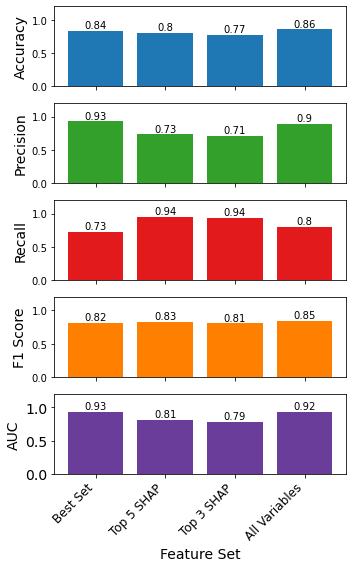

In [136]:
# Define the metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
set1_palette = ['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a', '#a6cee3', '#b2df8a']

# Create subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(5, 8), sharex=True)

# Plot each metric on a separate subplot
for i, metric in enumerate(metrics):
    ax = axes[i]
    colors = [set1_palette[i]] * len(gmm_summary_stats['site'])
    colors[0] = 'none'  # Make the first bar transparent
    bars = ax.bar(gmm_summary_stats['site'], gmm_summary_stats[metric], color=set1_palette[i])
    # Add values above the bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom', fontsize=10)

    # ax.set_yticks(fontsize=12)
    ax.set_ylabel(metric, fontsize=14)
    ax.set_ylim(0, 1.2)
# Set common X-axis label and adjust layout
axes[-1].set_xlabel('Feature Set', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks( fontsize=14)
plt.tight_layout()

# Show the plot
plt.show()

<Figure size 720x432 with 0 Axes>

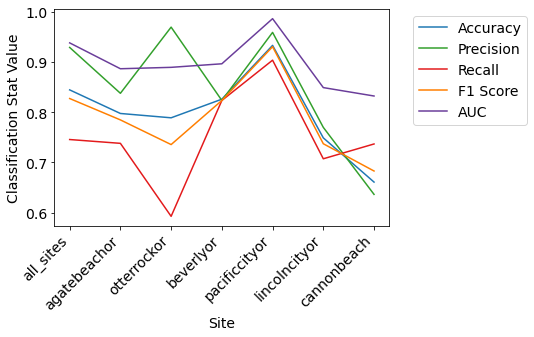

In [95]:
# sns.set_palette("Set1")
plt.figure(figsize=(10, 6))
ax = gmm_summary_stats.plot(x = 'site', color=set1_palette)
plt.xlabel('Site', fontsize = 14)
plt.ylabel('Classification Stat Value', fontsize = 14)
# plt.tight_layout()  # Ensure labels are not cut off
plt.tick_params(axis='both', labelsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
lgnd = plt.legend(
    # title='Custom Label', 
                  bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 14 
                                                                   })


In [270]:
gmm_summary_stats.to_csv('gmm_outputs_sites/gmm_summary_stats.csv'
,index = False)

precision_recall.to_csv('gmm_outputs_sites/precision_recall.csv'
,index = False)
roc.to_csv('gmm_outputs_sites/roc.csv'
,index = False)
y_info.to_csv('gmm_outputs_sites/y_info.csv'
,index = False)

In [281]:
precision_recall

,site,precision_array,recall_array
0,all_sites,0.499383,1.000000
1,all_sites,0.503731,1.000000
2,all_sites,0.504359,1.000000
3,all_sites,0.504988,1.000000
4,all_sites,0.505618,1.000000
...,...,...,...
109,cannonbeach,1.000000,0.070175
110,cannonbeach,1.000000,0.052632
111,cannonbeach,1.000000,0.035088
112,cannonbeach,1.000000,0.017544


In [164]:
compare = pd.DataFrame({'actual':y_test, 'pred':y_test_pred})
pd.crosstab(compare['pred'], compare['actual'])

actual,0,1
pred,,
0,395,98
1,92,389


In [97]:
gmm.predict_proba(X_test)

array([[9.99999999e-01, 7.70222964e-10],
       [9.86462685e-01, 1.35373147e-02],
       [1.87975211e-08, 9.99999981e-01],
       ...,
       [1.00000000e+00, 4.63735144e-16],
       [1.00000000e+00, 2.98963405e-26],
       [1.00000000e+00, 1.71512365e-16]])

In [102]:
gmm.predict_proba(X_test)

array([[9.99999999e-01, 7.70222964e-10],
       [9.86462685e-01, 1.35373147e-02],
       [1.87975211e-08, 9.99999981e-01],
       ...,
       [1.00000000e+00, 4.63735144e-16],
       [1.00000000e+00, 2.98963405e-26],
       [1.00000000e+00, 1.71512365e-16]])

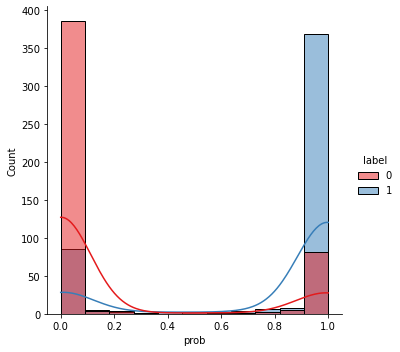

In [172]:
df = pd.DataFrame({'prob':y_scores,'label':y_test })
sns.displot(data=df, x='prob', hue='label', kde=True, palette='Set1')

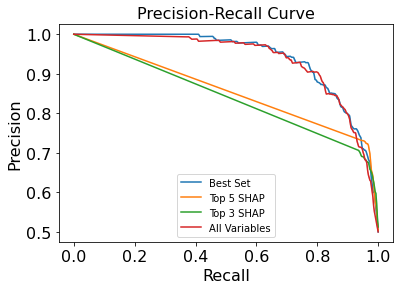

In [137]:
# precision_recall = precision_recall.reset_index()
# Plot precision-recall curve
# plt.figure(figsize=(8, 6))
# plt.plot(recall, precision, label='Precision-Recall curve')
sns.lineplot(x='recall_array', y='precision_array', hue='site'
             , data =precision_recall.loc[precision_recall['site']!='All Sites'] )
plt.xlabel('Recall', fontsize = 16)
plt.ylabel('Precision', fontsize = 16)
plt.tick_params(axis='both', which='both', labelsize=16)
plt.title('Precision-Recall Curve', fontsize=16)
plt.legend(prop={'size': 10 }, loc = 'lower center')
plt.show()

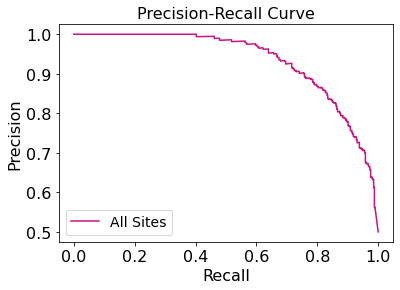

In [103]:
# precision_recall = precision_recall.reset_index()
# Plot precision-recall curve
# plt.figure(figsize=(8, 6))
# plt.plot(recall, precision, label='Precision-Recall curve')
plt.plot(precision_recall.loc[precision_recall['site']=='All Sites','recall_array']
         , precision_recall.loc[precision_recall['site']=='All Sites','precision_array']
             # , data =
         , color='mediumvioletred', label = 'All Sites'   )
plt.xlabel('Recall', fontsize = 16)
plt.ylabel('Precision', fontsize = 16)
plt.tick_params(axis='both', which='both', labelsize=16)
plt.title('Precision-Recall Curve', fontsize=16)
plt.legend(prop={'size': 14 }, loc = 'lower left')
plt.show()



In [77]:
roc

,site,fpr,tpr
0,all_sites,0.000000,0.000000
1,all_sites,0.000000,0.002469
2,all_sites,0.000000,0.424691
3,all_sites,0.002463,0.424691
4,all_sites,0.002463,0.449383
...,...,...,...
30,cannonbeach,0.482759,0.982456
31,cannonbeach,0.844828,0.982456
32,cannonbeach,0.844828,1.000000
33,cannonbeach,0.965517,1.000000


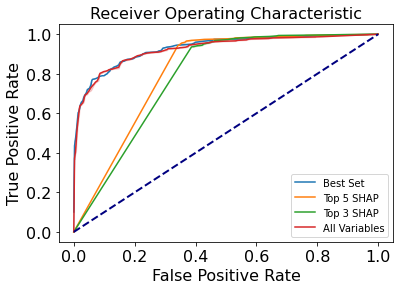

In [138]:
# roc = roc.reset_index()
plt.figure()
sns.lineplot(x='fpr', y='tpr', hue='site'
             , data =roc.loc[roc['site']!='All Sites'] )
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver Operating Characteristic', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=16)

plt.legend(loc="lower right")
plt.show()

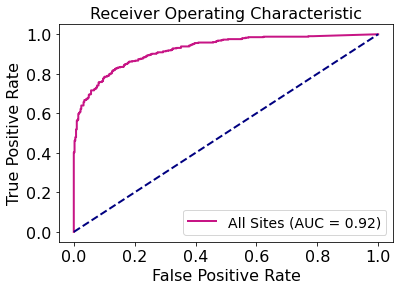

In [96]:
# roc = roc.reset_index()
plt.figure()
# sns.lineplot(x='fpr', y='tpr', hue='site', data =roc.loc[roc['site']=='All Sites'] )
plt.plot(roc.loc[roc['site']=='All Sites','fpr'], roc.loc[roc['site']=='All Sites','tpr']
         , color='mediumvioletred', lw=2
         , label='All Sites (AUC = %0.2f)' % gmm_summary_stats.loc[gmm_summary_stats['site']=='All Sites','AUC'])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver Operating Characteristic', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=16)
plt.legend(loc="lower right",prop={'size': 14 })
plt.show()

In [79]:
gmm_summary_stats


,site,Accuracy,Precision,Recall,F1 Score,AUC
0,All Sites,0.824908,0.914826,0.716049,0.803324,0.922995
0,Agate Beach,0.863095,0.886076,0.833333,0.858896,0.932681
0,Otter Rock,0.844037,0.877551,0.796296,0.834951,0.897643
0,Beverly,0.884058,0.906250,0.852941,0.878788,0.902521
0,Pacific City,0.923810,0.978261,0.865385,0.918367,0.982946
0,Lincoln City,0.825911,0.838983,0.804878,0.821577,0.885327
0,Cannon Beach,0.643478,0.629032,0.684211,0.655462,0.720508


In [11]:
##### support vector machine
threshold = 0.5

#SVM using RBF kernel
from sklearn import svm
regr = svm.SVR(kernel='rbf')
regr.fit(X_train, y_train)

y_train_pred = regr.predict(X_train)
y_train_pred_binary = (y_train_pred > threshold).astype(int)
train_accuracy = np.mean(y_train_pred_binary.ravel() == y_train.ravel())
print( 'Train accuracy: %.2f' % train_accuracy)

y_test_pred = regr.predict(X_test)
y_test_pred_binary = (y_test_pred > threshold).astype(int)
test_accuracy = np.mean(y_test_pred_binary.ravel() == y_test.ravel())
print('Test accuracy: %.2f' % test_accuracy)


Train accuracy: 0.94
Test accuracy: 0.92


In [12]:
accuracy = accuracy_score(y_test, y_test_pred_binary)
precision = precision_score(y_test, y_test_pred_binary)
recall = recall_score(y_test, y_test_pred_binary)
f1 = f1_score(y_test, y_test_pred_binary)
roc_auc = roc_auc_score(y_test, regr.predict(X_test))

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC-ROC Score:", roc_auc)

Accuracy: 0.9194669756662804
Precision: 0.8461538461538461
Recall: 0.7436619718309859
F1 Score: 0.7916041979010494
AUC-ROC Score: 0.9511654903894556


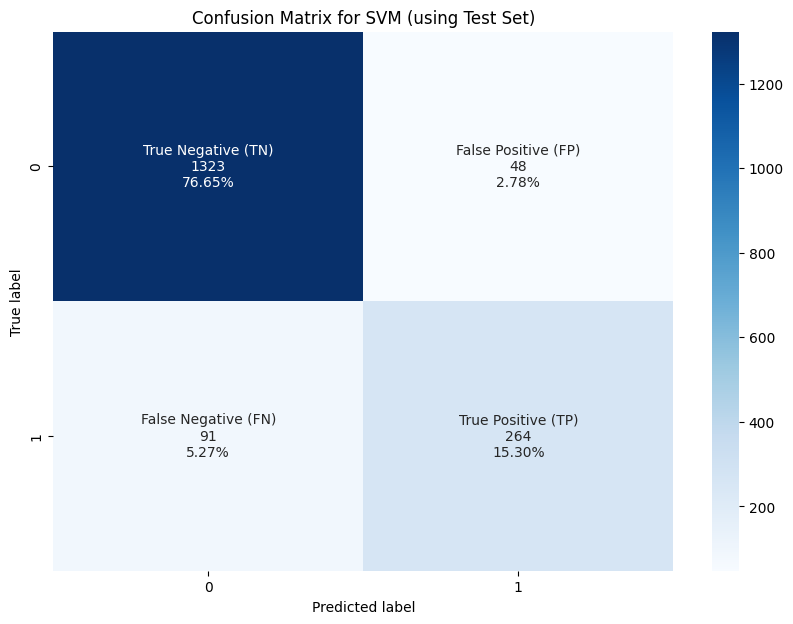

In [13]:
plot_confusion_matrix(y_test, y_test_pred_binary, "SVM")

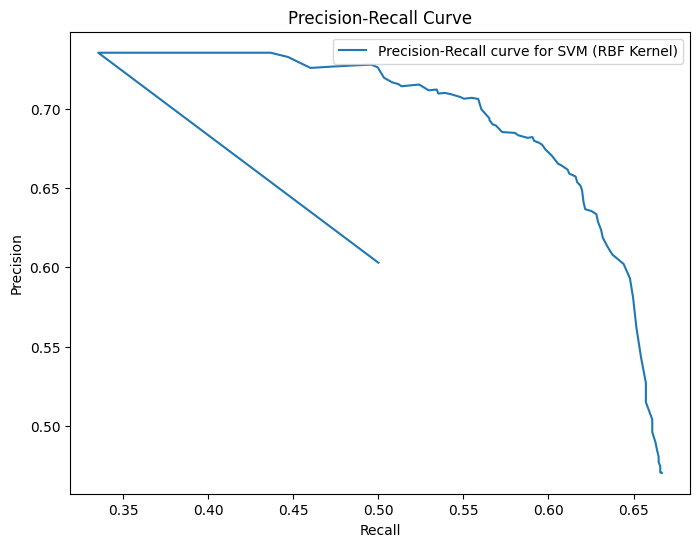

In [14]:
y_scores = regr.predict(X_test)

# Generate a range of thresholds from the minimum to the maximum predicted scores
thresholds = np.linspace(min(y_scores), max(y_scores), 100)

# Initialize lists to store precision and recall values
precisions = []
recalls = []

for t in thresholds:
  # Convert continuous predictions to binary predictions based on the current threshold
  y_pred_binary = (y_scores > t).astype(int)

  # Calculate precision and recall
  precision, recall, _ = precision_recall_curve(y_test, y_pred_binary)

  # Store the average precision and recall for the current threshold
  precisions.append(np.mean(precision))
  recalls.append(np.mean(recall))

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label='Precision-Recall curve for SVM (RBF Kernel)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

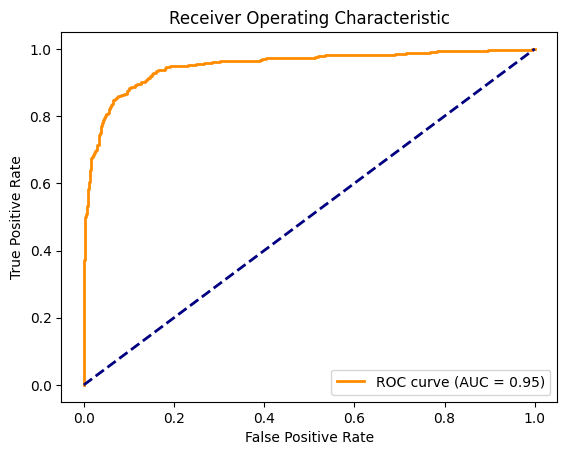

In [15]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, regr.predict(X_test))
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [16]:
#SVM using linear kernel
regr_linear = svm.SVR(kernel='linear')
regr_linear.fit(X_train, y_train)

y_train_pred = regr_linear.predict(X_train)
y_train_pred_binary = (y_train_pred > threshold).astype(int)
train_accuracy = np.mean(y_train_pred_binary.ravel() == y_train.ravel())
print('Train accuracy for SVM with linear kernel: %.2f' % train_accuracy)

y_test_pred = regr_linear.predict(X_test)
y_test_pred_binary = (y_test_pred > threshold).astype(int)
test_accuracy = np.mean(y_test_pred_binary.ravel() == y_test.ravel())
print('Test accuracy for SVM with linear kernel: %.2f' % test_accuracy)

Train accuracy for SVM with linear kernel: 0.89
Test accuracy for SVM with linear kernel: 0.88


In [17]:
#SVM using polynomial kernel
regr_poly = svm.SVR(kernel='poly', degree=3)
regr_poly.fit(X_train, y_train)

y_train_pred = regr_poly.predict(X_train)
y_train_pred_binary = (y_train_pred > threshold).astype(int)
train_accuracy = np.mean(y_train_pred_binary.ravel() == y_train.ravel())
print( 'Train accuracy for SVM with polynomial kernel of degree 3: %.2f' % train_accuracy)

y_test_pred = regr_poly.predict(X_test)
y_test_pred_binary = (y_test_pred > threshold).astype(int)
test_accuracy = np.mean(y_test_pred_binary.ravel() == y_test.ravel())
print('Test accuracy for SVM with polynomial kernel of degree 3: %.2f' % test_accuracy)

Train accuracy for SVM with polynomial kernel of degree 3: 0.91
Test accuracy for SVM with polynomial kernel of degree 3: 0.90


In [18]:
#SVM using sigmoid kernel
regr_sigmoid = svm.SVR(kernel='sigmoid')
regr_sigmoid.fit(X_train, y_train)

y_train_pred = regr_sigmoid.predict(X_train)
y_train_pred_binary = (y_train_pred > threshold).astype(int)
train_accuracy = np.mean(y_train_pred_binary.ravel() == y_train.ravel())
print( 'Train accuracy for SVM with sigmoid kernel: %.2f' % train_accuracy)

y_test_pred = regr_sigmoid.predict(X_test)
y_test_pred_binary = (y_test_pred > threshold).astype(int)
test_accuracy = np.mean(y_test_pred_binary.ravel() == y_test.ravel())
print('Test accuracy for SVM with sigmoid kernel: %.2f' % test_accuracy)

Train accuracy for SVM with sigmoid kernel: 0.46
Test accuracy for SVM with sigmoid kernel: 0.46


In [19]:
#### GMM

gmm = GaussianMixture(n_components=n_classes
                    # ,covariance_type='diag'
                      , init_params='random_from_data')
gmm.fit(X_train)
y_train_pred = gmm.predict(X_train)
train_accuracy = np.mean(y_train_pred == y_train)
print( 'Train accuracy: %.2f' % train_accuracy)

y_test_pred = gmm.predict(X_test)
test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel())
print('Test accuracy: %.2f' % test_accuracy)


Train accuracy: 0.32
Test accuracy: 0.33


In [20]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, gmm.predict_proba(X_test)[:, 1])

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC-ROC Score:", roc_auc)

Accuracy: 0.32966396292004635
Precision: 0.07066381156316917
Recall: 0.18591549295774648
F1 Score: 0.10240496508921645
AUC-ROC Score: 0.18164185697701896


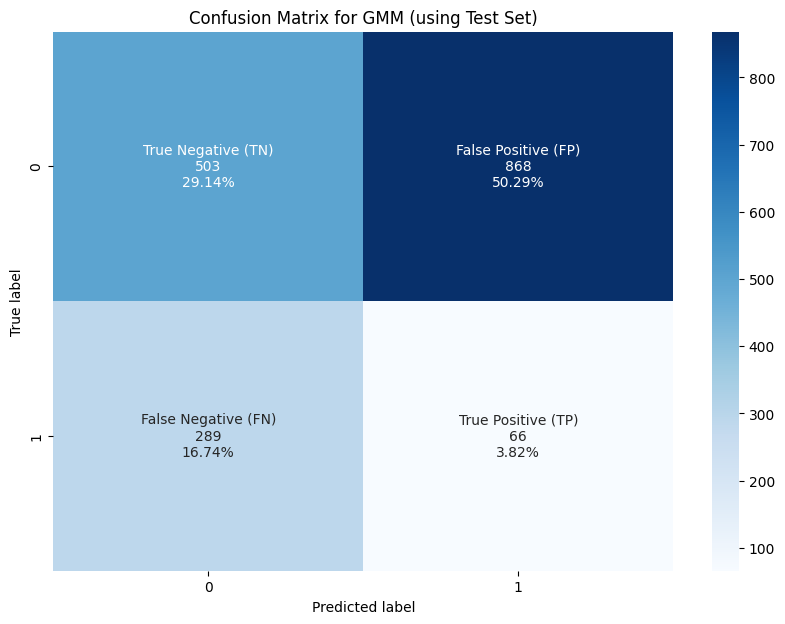

In [21]:
plot_confusion_matrix(y_test, y_test_pred, "GMM")

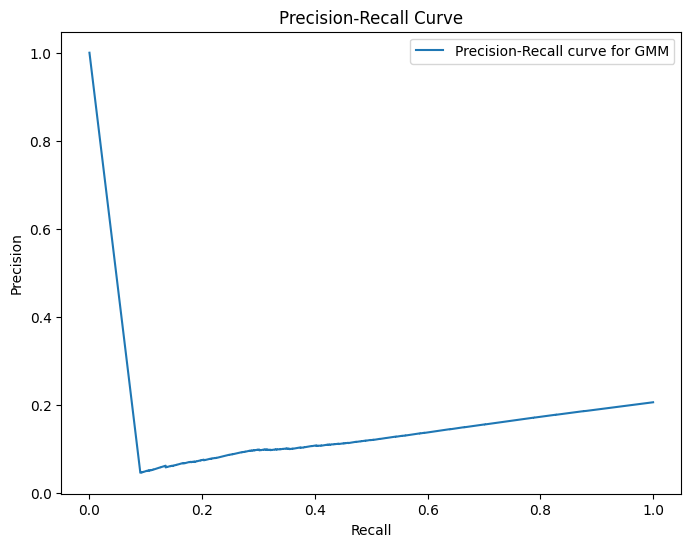

In [22]:
y_scores = gmm.predict_proba(X_test)

y_scores_class = y_scores[:, 1]

# Calculate precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores_class)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall curve for GMM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

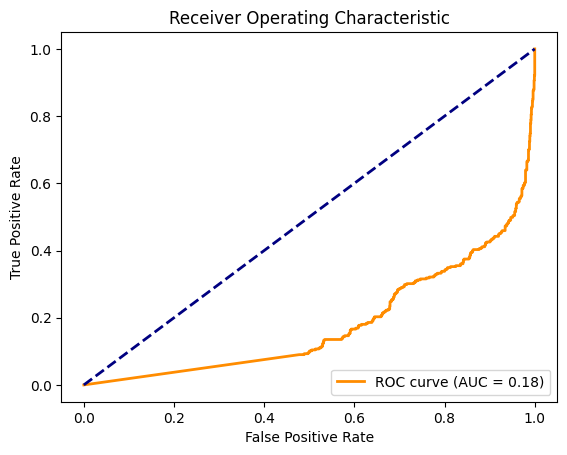

In [23]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, gmm.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()